# 3. Convolutional Neural Networks (60 pts)

### Implement the convolutional neural network shown below for CIFAR-10 dataset.  Your code must follow these rules:

__- Use your own implementation.__

__- You can only use " tf " and " tf.nn " libraries for version 1 (40 pts). Check [tf.nn](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/nn)__

__- You can use " tf.layers " library for version 2 (20 pts). Check [tf.layers](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/layers)__

__- Use ReLU activation function__

__- Use batch normalization for convolutional layers__

__- Use dropout for fully connected layers (for training only)__

__- Write necessary explanations for each cell. Explanations should be detailed.__

__- You can use codes from Lab Notebook.__

__- (OPTIONAL) You can add more layers or use different methods for better accuracy. If you want, send an another notebook file with better accuracy for bonus points.__

<img src="https://github.com/METU-MMI-DeepLearning/MMI713_Deep_Learning/blob/master/Assignment%202/model.png?raw=1">

## Imports

In [1]:
%tensorflow_version 1.x" before "import tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x" before "import tensorflow`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


## Load Data

You can normalize input data "x" if needed. You can use "np.squeeze" to remove single-dimensional entries from the shape of an array. You probably need to convert labels "y" to one-hot vector for loss function.

*Load* the CIFAR10 dataset

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

Normalize the x input data

In [3]:
n_classes = 10

X_train_mean = np.mean(x_train, axis=(0,1,2))
X_train_std = np.std(x_train, axis=(0,1,2))
x_train = (x_train - X_train_mean) / X_train_std
x_test = (x_test - X_train_mean) / X_train_std

print("x_train:")
print(x_train.shape)


x_train:
(50000, 32, 32, 3)


Convert y data to one-hot vector form

In [4]:
print("y_train:")
y_train = np.squeeze(y_train)
y_train = np.eye(np.max(y_train) + 1)[y_train]
print(y_train.shape)
print(y_train[0])

print("y_test:")
y_test = np.squeeze(y_test)
y_test = np.eye(np.max(y_test) + 1)[y_test]
print(y_test.shape)


y_train:
(50000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
y_test:
(10000, 10)


## Define placeholders

Define input and output placeholders. It is a good idea to pass dropout rate also as a placeholder.

We define the placeholder **x** for the input data with no specific number of samples but with dimensions of a single sample.
We define **y** with no sample number either but with dimensions of a one-hot vector.
**dropout** placeholder is the dropout rate for use to be able to specify the dropout rate during training and to disable the process during test time.

In [0]:
dropout_rate = 0.5

x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.float32, [None, n_classes])
dropout = tf.placeholder(tf.float32)

## Define network

Define the network as a function.Recommended functions are:

`
tf.nn.convolution / tf.nn.pool / tf.nn.batch_normalization / tf.nn.dropout / tf.reshape`

The convolution layer method constituted by convolution, adding bias, batch normalziation and ReLU activation.

In [0]:
def conv_layer(x, output_channel, kernel_size=[5,5], strides=[1,1], padding="SAME"):
  x = tf.layers.conv2d(x,
                       output_channel,
                       kernel_size,
                       strides,
                       padding, 
                       activation=tf.nn.relu,
                       use_bias=True, kernel_initializer=tf.glorot_normal_initializer(),
                       trainable=True
                       )
  #x = tf.layers.batch_normalization(x, axis=1)
  x = batch_norm(x, output_channel)
  return x

Max pooling layer using the tf.layers.max_pooling function with setting of max pooling

In [0]:
def maxpool_layer(x, window=[3,3], strides=[2,2], padding="SAME"):
  return tf.layers.max_pooling2d(x, window, strides, padding)


The definition of the CNN. It has convolution, max pooling and dense layers. 

In [0]:

def conv_net(x, dropout_rate):
  
  x = conv_layer(x, 32)
  x = maxpool_layer(x)
  x = conv_layer(x, 16)
  x = maxpool_layer(x)
  x = conv_layer(x, 32)
  x = maxpool_layer(x)
  
  x = tf.layers.flatten(x)
  
  x = tf.layers.batch_normalization(x)
  x = dense_layer(x, 128, dropout_rate, activation=tf.nn.relu)
  logits = dense_layer(x, n_classes, dropout_rate, activation=None)
  prediction = tf.nn.softmax(logits)

  return logits, prediction


The dense layer definition which does matrix multiplication with the input and the weights and adds the biases. Then, it applies activation and dropout in order.

In [0]:
def dense_layer(x, units, dropout, activation=tf.nn.relu):
  if activation is None:
    x = tf.layers.dense(x, units, kernel_initializer=tf.glorot_uniform_initializer(), trainable=True)
  else :
    x = tf.layers.dense(x, units, activation=activation, kernel_initializer=tf.glorot_uniform_initializer(), trainable=True)

  x = tf.layers.dropout(x, rate=dropout)
  

  return x

Batch normalization layer creates 2 variables every time it is used which are trainable. The batch of inputs is normalized by its mean and variance with the parametrized scaling factors. 

In [0]:
def batch_norm(x, n_out):
    beta = tf.Variable(tf.constant(0.0, shape=[n_out]), trainable=True)
    gamma = tf.Variable(tf.constant(1.0, shape=[n_out]), trainable=True)
    mean, var = tf.nn.moments(x, [0, 1, 2])
    normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

Define the CNN. Outputs are the logits and the spftmax outputs separated.

In [11]:
logits, prediction = conv_net(x, dropout)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use keras.layers.dropout instead.


## Define cost function

Define cost with respect to predictions and labels.

Define the cost function as the cross entropy

In [12]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
# cost = tf.reduce_mean(tf.squared_difference(prediction, y))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Define optimizer

Adam is recommended

Define the optimizer as Adam Optimizer

In [0]:
optimizer = tf.train.AdamOptimizer().minimize(cost)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost) 

## Define performance measures

The find the number of correct predictions and calculate the overall accuracy

In [0]:
correct_prediction = tf.equal(tf.argmax(prediction, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Create TensorFlow session


In [0]:
session = tf.Session()

## Initialize variables

The variables for `weights`,`filters` and `biases` must be initialized before we start optimizing them.

In [16]:
init = tf.initialize_all_variables()
session.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


## Define train function

Don't forget to use batches since dataset is large.

Hint : One of the simplest way to define batch is

`for b in range(dataset_size//batch_size):      
    x_batch = x_train[b * batch_size : (b+1) * batch_size]`

In [0]:
train_accuracy_on_epoch = []
train_loss_on_epoch = []

test_accuracy_on_epoch = []
test_loss_on_epoch = []



The train function that inputs a batch to the network and gets the accuracy and loss. Then, at the end of each batch, it runs the network with the test set.

In [0]:

def train(epoch_num, batch_size):
  for i in range(epoch_num):
    batch_loss = []
    batch_acc = []
    for b in range(len(x_train)//batch_size): 
      x_batch = x_train[b * batch_size : (b+1) * batch_size]  
      y_batch = y_train[b * batch_size : (b+1) * batch_size]
      _, acc, loss, p = session.run([optimizer, accuracy, cost, prediction], feed_dict={x:x_batch, y: y_batch, dropout:dropout_rate})
      batch_loss.append(loss)
      batch_acc.append(acc)
    #print(p)
    train_accuracy_on_epoch.append(np.mean(np.array(batch_acc)))
    train_loss_on_epoch.append(np.mean(np.array(batch_loss)))
    
    acc, loss = test(x_test, y_test, i+1)
    test_accuracy_on_epoch.append(acc)
    test_loss_on_epoch.append(loss)
    



## Define test function

The test function taht feeds the test set to the network. We specify dropout to be 1.0 to avoid it.

In [0]:

def test(x_set, y_set, epoch_no):
  test_acc, loss, p = session.run([accuracy, cost, prediction], feed_dict={x: x_set, y: y_set, dropout:0})
  print("Epoch:{} Accuracy:{} Loss:{} ".format(epoch_no, test_acc, loss))
  #print(p)
  return test_acc, loss
  

## Performance before training

The accuracy is expected to be around 10%

In [20]:
acc, loss = test(x_test, y_test, 0)

Epoch:0 Accuracy:0.13249999284744263 Loss:3.363022565841675 


## Performance after training

Measure training and test accuracy for at least 10 epochs, show it on a epoch/accuracy graph. The network is expected to reach around 70% accuracy at 10 epochs. 

In [21]:
epoch_number = 50
batch_size = 1000
start_time = time()
train(epoch_number, batch_size)
end_time = time()
print("Took {} seconds to train for {} epochs with batch size {}. Time consumed for 1 epochs is {} seconds".format(end_time - start_time, epoch_number, batch_size, (end_time - start_time)/epoch_number))

Epoch:1 Accuracy:0.5145999789237976 Loss:1.3562874794006348 
Epoch:2 Accuracy:0.5760999917984009 Loss:1.1724324226379395 
Epoch:3 Accuracy:0.6201000213623047 Loss:1.0696786642074585 
Epoch:4 Accuracy:0.6478000283241272 Loss:0.9978162050247192 
Epoch:5 Accuracy:0.6561999917030334 Loss:0.9734954833984375 
Epoch:6 Accuracy:0.6636999845504761 Loss:0.9535968899726868 
Epoch:7 Accuracy:0.6748999953269958 Loss:0.9243316650390625 
Epoch:8 Accuracy:0.6825000047683716 Loss:0.9065669775009155 
Epoch:9 Accuracy:0.6919000148773193 Loss:0.8775367140769958 
Epoch:10 Accuracy:0.6912000179290771 Loss:0.8930172920227051 
Epoch:11 Accuracy:0.6942999958992004 Loss:0.8919121026992798 
Epoch:12 Accuracy:0.6947000026702881 Loss:0.8936574459075928 
Epoch:13 Accuracy:0.701200008392334 Loss:0.890246570110321 
Epoch:14 Accuracy:0.697700023651123 Loss:0.8982469439506531 
Epoch:15 Accuracy:0.6955999732017517 Loss:0.9081863164901733 
Epoch:16 Accuracy:0.6930999755859375 Loss:0.9201202988624573 
Epoch:17 Accuracy:0.

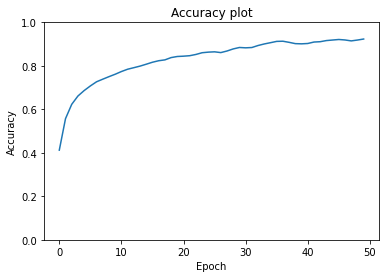

Accuracy on train-set: 92.3%


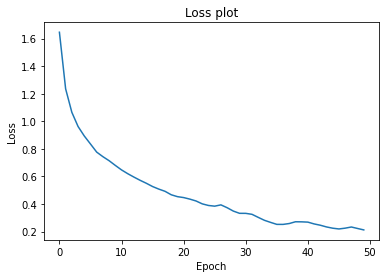

Loss on train-set: 0.21165910363197327


In [22]:
plt.plot(train_accuracy_on_epoch)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(top=1.0, bottom=0.0)
plt.title("Accuracy plot")
plt.show()
print("Accuracy on train-set: {0:.1%}".format(train_accuracy_on_epoch[-1]))

plt.plot(train_loss_on_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss plot")
plt.show()
print("Loss on train-set: {}".format(train_loss_on_epoch[-1]))

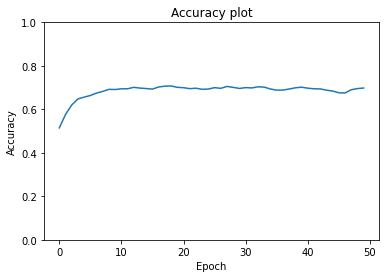

Accuracy on test-set: 69.8%


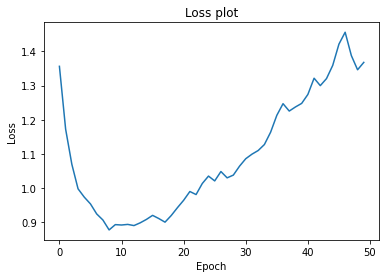

Loss on test-set: 1.3678240776062012


In [23]:
plt.plot(test_accuracy_on_epoch)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(top=1.0, bottom=0.0)
plt.title("Accuracy plot")
plt.show()
print("Accuracy on test-set: {0:.1%}".format(test_accuracy_on_epoch[-1]))

plt.plot(test_loss_on_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss plot")
plt.show()
print("Loss on test-set: {}".format(test_loss_on_epoch[-1]))


## Close the session

In [0]:
session.close()

## Discussion

In this part of the assignment, I have used the tf.layers, tf.nn and tf libraries to implement a CNN to classify the images of the CIFAR10 dataset. The network contains several types of layers:

*   Convolutional Layers
*   Max Pooling Layers
*   Batch Normalization Layers
*   Flattening Layer
*   Fully Connected Layers
*   Dropout Layers

All the weights of the network are initialized with Xavier initialization method which seems to perform considerably better compared to the random uniform or random normal initializations. The convolutional layers are always followed by adding bias, batch normalization and ReLU activation. The batch normalization normalizes the batch of activations to a 0 mean and 1 variance which fights the internal covariate shift. It also makes the network faster and on top of all regularizes the tensor which can make finding correlations easier. The max pooling layers subsample the activations taken from the convolutional layers, who change the depth of the activation maps by having different numbers of kernels. The feature extraction part of the network is constituted by 3 convolutional and 3 max pooling layers. The classification is done inside a fully connected neural network which starts with the flattening layer which flattens the activation map taken from the last pooling layer of the feature extraction. The dense network contains one hidden layer that also contains a dropout layer which randomly deactivates neurons to prevent overfitting, by letting the network to find different paths to a decision. The last layer applies softmax activation to the logits and gives the predictions. As the cost function, cross entropy was chosen. The learning process was set to minimize this cost function with the help of the Adam optimizer. 

Using tf.layers library has its pros and cons. This library is a slightly higher library than the tf.nn altough I personally like converting the low level API to a slightly higher level. Also, this library seems to be more optimized than tf.nn as I got more consistent accuracies in 10 epochs compared to the varying accuracies of tf.nn. I mostly got 70% after each training with 10 epochs. However, training and infering with this library seems to be much slower than the lower level one. Time consumption of training with one epoch is around 5.5s which is more than twice of the training time consumption of tf.nn. I have also realized that using the batch normalization layer given by this library is much easier to use than tf.nn.batch_normalization function since it gives default values tot he normalization parameters. However, I saw that rather than using these default parameters, making them trainable parameters of the network provides better results, by having a small overhead. The main problem I have faced was that despite having the exact same architecture and same number of paramters as the network I have built in the previous part, this network seems to have a smaller learning capacity, such that after around 20 epochs the test accuracy gets stuck around 70-71% With a 150 epochs of training, while the training accuracy went to 100%, the test accuracy still got stuck at 70%. Also, the test loss diverges after 18th epoch. This is a clear indication of overfitting on the train set. But it is interesting how the same parameters can give vastly different  And considering that the inference time is considerably longer than the low level API, it can be argued that using this high-level API almost seems redundant. 

I saw that using the higher level libraries do not necessarily give the most optimized results. Ease of implementation is a big advantage considering the fact that the implementaiton of deep networks can easily get confusing and hard to keep track of; however, it is crucial to first know the basics of the high level APIs.

## References

[1] [Arm Community](https://community.arm.com)